In [ ]:
%matplotlib inline

# NLP: Machine Translation with a Sequence to Sequence Network and Attention

This tutorial is adapted from [the PyTorch Tutorials](https://pytorch.org/tutorials/) and [Sean Robertson](https://github.com/spro), valuable references for learning the fundamentals of Natural Language Processing in PyTorch. We highly recommend exploring other tutorials for deeper understanding and additional topics.

We'll guide you through building and training your own Machine Translation Network using a Sequence to Sequence Network (seq2seq) and Attention, starting from scratch. We'll break down the process into bite-sized steps, focusing on the essential building blocks of NLP from data preprocessing to training and evaluation. By crafting each component yourself, you'll gain a deep understanding of how Sequence to Sequence Network and Attention handle text data and perform machine translation.

Specifically, we'll train the seqsSeq Network to translate from French to English:

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

**Transforming sequences with the power of sequence-to-sequence networks:**

* **Harnessing two minds for one task:** [Sequence-to-sequence networks (or seq2seq)](https://arxiv.org/abs/1409.3215)  employ a pairing of two recurrent neural networks to achieve sequence transformation.
* **Condensing and expanding information:** The encoder network analyzes the input sequence and distills it into a compact vector representation. This vector acts as a rich summary of the essential information.
* **Unfolding a new story:** The decoder network then takes on the task of interpreting this vector, gradually unfolding its meaning into a brand-new sequence.

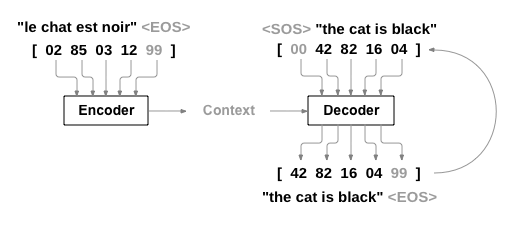

**Enhancing focus with attention:**

* **Precision over broad strokes:** To improve this process, we use the [attention mechanism](https://arxiv.org/abs/1409.0473). This mechanism empowers the decoder to selectively focus on specific segments of the input sequence during decoding.
* **Learning what matters most:** This selective attention allows the model to dynamically prioritize the most relevant parts of the input, leading to more accurate and nuanced output sequences.

**Key takeaways:**

* Seq2Seq networks offer a versatile framework for tackling a wide range of sequence-to-sequence tasks.
* The attention mechanism provides a powerful tool for refining model performance and producing more context-aware output.
* By understanding these concepts, we can unlock the potential to create more intelligent and adaptable systems capable of handling complex sequential data.

In [ ]:
# Importing necessary modules
import sys  # Module for interacting with the Python interpreter
import os   # Module for interacting with the operating system

# Checking if the code is running in Google Colab
if 'google.colab' in sys.modules:
    print(f"Running in Google Colab ...")
    # Setting the data directory path for Google Colab environment
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = os.path.join('/content/drive/My Drive', 'data')
else:
    # Code is running in a local setup
    print(f"Running in Local Setup ...")
    # Setting the data directory path for local environment
    data_dir = os.path.join('.', 'data')

# Displaying the selected data directory
print(f"Using Data Directory: {data_dir}")

In [ ]:
# Enable features for Python 3 compatibility (even if running Python 2)
from __future__ import unicode_literals, print_function, division  # Ensures consistent behavior across Python versions

# Import necessary libraries
from io import open  # For opening files with flexible encoding
import unicodedata  # For working with Unicode characters
import re  # For regular expression operations
import random  # For random number generation

# Import PyTorch and related modules for deep learning
import torch  # Core PyTorch library
import torch.nn as nn  # Building neural networks
from torch import optim  # Optimizers for training neural networks
import torch.nn.functional as F  # Additional functional layers and operations

# Import NumPy for numerical computations
import numpy as np  # Handling numerical data arrays

# Import data handling utilities from PyTorch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler  # Creating datasets and data loaders

In [ ]:
# Determine the optimal device for computations, prioritizing GPUs and MPS:
device = torch.device(
    "cuda"  # Prioritize GPU if available
    if torch.cuda.is_available()
    else "mps"  # use MPS if available
    if torch.backends.mps.is_available()
    else "cpu"  # Fallback to CPU
)

# Print the selected device for clarity:
print(f"Torch Device: {device}")

## Loading data files

We will use a set of many thousands of English-French translation pairs in this tutorial. 

The English to French pairs are located in ``data/eng-fra.txt``.

::

    I am cold.    J'ai froid.

**Mapping words to their unique numerical addresses:**

- We'll assign a special numerical code, a "one-hot vector," to each word in our vocabulary. It's like giving every word its own unique apartment in a vast building, where each apartment's number represents a word.
- To keep things manageable, we'll focus on creating a curated vocabulary of a few thousand words per language. Think of it as choosing the most vibrant neighborhoods in our word city!

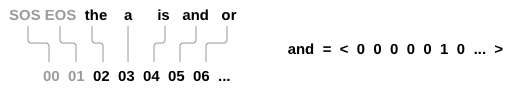

**Creating a language organizer:**

- To ensure each word has a distinct address within our model, we'll assign unique numerical indices to them. These indices will act as roadmaps for our networks when navigating through sentences.
- To manage this efficiently, we'll create the `Lang` class. This class will maintain the following:
    - **Word-to-index dictionary (`word2index`):** A quick reference guide that maps each word to its corresponding numerical index.
    - **Index-to-word dictionary (`index2word`):** The reverse lookup tool, allowing us to retrieve the word associated with a given index.
    - **Word count tracker (`word2count`):** A count of word occurrences, essential for identifying and handling rare words later on.


In [ ]:
# Define special tokens for Start-of-Sequence (SOS) and End-of-Sequence (EOS)
SOS_token = 0
EOS_token = 1

# Define a class called Lang for language processing
class Lang:
    # Constructor to initialize the language object with a name
    def __init__(self, name):
        """
        Constructor for the Lang class.
    
        Args:
        - name: The name of the language.
    
        Attributes:
        - name: Stores the name of the language.
        - word2index: Dictionary to map words to their indices.
        - word2count: Dictionary to store the count of each word.
        - index2word: Dictionary to map indices to words, including special tokens (SOS and EOS).
        - n_words: Initialize the total number of words to 2 (SOS and EOS).
    
        Returns:
        - None
        """
        self.name = name          # Store the name of the language
        self.word2index = {}      # Dictionary to map words to their indices
        self.word2count = {}      # Dictionary to store the count of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # Dictionary to map indices to words, including special tokens
        self.n_words = 2          # Initialize the total number of words to 2 (SOS and EOS)

    # Method to add a sentence to the language
    def add_sentence(self, sentence):
        """
        Method to add a sentence to the language.
    
        Args:
        - sentence: Input sentence as a string.
    
        Returns:
        - None
        """
        # Split the sentence into words and add each word to the language
        for word in sentence.split(' '):
            self.add_word(word)

    # Method to add a word to the language
    def add_word(self, word):
        """
        Method to add a word to the language.
    
        Args:
        - word: The word to be added.
    
        Returns:
        - None
        """
        # If the word is not already in the dictionary, add it
        if word not in self.word2index:
            self.word2index[word] = self.n_words   # Assign a unique index to the word
            self.word2count[word] = 1              # Initialize the word count to 1
            self.index2word[self.n_words] = word   # Map the index to the word
            self.n_words += 1                      # Increment the total word count
        else:
            self.word2count[word] += 1             # If the word is already in the dictionary, increment its count

**Streamlining text for translation:**

- We'll turn all characters to their ASCII equivalents.
- We'll also turn each word into lowercase.
- Finally, we'll trim away most punctuation.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
# Function to convert Unicode text to ASCII
def unicode_to_ascii(s):
    """
    Convert Unicode text to ASCII.

    Args:
    - s: Input Unicode text.

    Returns:
    - str: ASCII representation of the input text.
    """
    # Normalize the input string using Unicode Normal Form Decomposition (NFD)
    normalized_text = unicodedata.normalize('NFD', s)
    
    # Use a generator expression to create a string with non-mark characters
    # This filters out characters with the 'Mn' (Nonspacing_Mark) Unicode category
    # 'Mn' category includes diacritic marks such as accents
    return ''.join(c for c in normalized_text if unicodedata.category(c) != 'Mn')

In [ ]:
# Function to normalize a string
def normalize_string(s):
    """
    Normalize a string by converting it to ASCII, lowercase, and removing unnecessary characters.

    Args:
    - s: Input string to be normalized.

    Returns:
    - str: Normalized version of the input string.
    """
    # Convert the string to ASCII, lowercase, and remove leading/trailing whitespaces
    s = unicode_to_ascii(s.lower().strip())
    
    # Add spaces before punctuation marks (. ! ?) to separate them from words
    s = re.sub(r"([.!?])", r" \1", s)
    
    # Replace any non-alphabetic characters (except . ! ?) with a space
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    
    # Remove leading and trailing whitespaces
    return s.strip()

To read the data file, we will first split it into lines and then further split the lines into pairs. Since the files are structured as English → Other Language, if we intend to translate from Other Language → English, the `reverse` flag has been introduced to invert the pairs accordingly.

In [ ]:
# Function to read language pairs from a file and create language instances
def read_langs(lang1, lang2, reverse=False):
    """
    Read language pairs from a file and create language instances.

    Args:
    - lang1: Code for the first language.
    - lang2: Code for the second language.
    - reverse: Boolean indicating whether to reverse the language pairs.

    Returns:
    - input_lang: Instance of the Lang class for the first language.
    - output_lang: Instance of the Lang class for the second language.
    - pairs: List of language pairs.
    """
    print("Reading lines...")

    # Constructing a file path using os.path.join
    # The file name is dynamically created based on the values of lang1 and lang2
    data_file = os.path.join(data_dir, f'{lang1}-{lang2}.txt')

    # Read the file and split it into lines
    lines = open(data_file, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize each string in the pairs
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs and create Lang instances if specified
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    # Return the input language, output language, and the pairs
    return input_lang, output_lang, pairs

Due to the abundance of example sentences and the desire for a swift training process, we will narrow down the dataset to include only relatively short and straightforward sentences. The maximum length allowed is 10 words, including ending punctuation. Additionally, we are specifically filtering for sentences that translate into forms such as "I am" or "He is," taking into account earlier apostrophe replacements.

In [ ]:
# Maximum length for a sentence
MAX_LENGTH = 10

# Prefixes used for filtering sentences
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [ ]:
# Function to filter pairs of sentences based on length and prefixes
def filter_pair(p):
    """
    Filter pairs of sentences based on length and prefixes.

    Args:
    - p: Pair of sentences where p[0] is the first sentence and p[1] is the second sentence.

    Returns:
    - bool: True if the pair satisfies filtering conditions, False otherwise.
    """
    # Check if the length of the first and second sentences is less than MAX_LENGTH
    condition1 = len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH
    
    # Check if the second sentence starts with any of the specified English prefixes
    condition2 = p[1].startswith(eng_prefixes)

    # Return True if both conditions are satisfied, indicating the pair should be kept
    return condition1 and condition2

In [ ]:
# Function to filter a list of pairs using the filter_pair function
def filter_pairs(pairs):
    """
    Filter a list of pairs using the filter_pair function.

    Args:
    - pairs: List of pairs where each pair contains two sentences.

    Returns:
    - filtered_pairs: List of pairs that satisfy the filtering condition.
    """
    # Use a list comprehension to create a new list containing only 
    # the pairs that satisfy the filter_pair condition
    filtered_pairs = [pair for pair in pairs if filter_pair(pair)]
    
    # Return the filtered list of pairs
    return filtered_pairs

**The complete data preparation process involves the following steps:**

1. Read the text file, split it into lines, and further split the lines into pairs.
2. Normalize the text and filter it based on length and content criteria.
3. Generate word lists from the sentences in pairs.

In [ ]:
# Function to prepare language data
def prepare_data(lang1, lang2, reverse=False):
    """
    Prepare language data for translation.

    Args:
    - lang1: Code for the source language (e.g., 'eng').
    - lang2: Code for the target language (e.g., 'fra').
    - reverse: Boolean indicating whether to reverse the language pairs.

    Returns:
    - input_lang: Language instance for the source language.
    - output_lang: Language instance for the target language.
    - pairs: List of filtered sentence pairs.
    """
    # Read language pairs and create language instances
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    
    # Filter pairs based on length and prefixes
    pairs = filter_pairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    
    print("Counting words...")

    # Iterate through each pair and add sentences to language instances
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    # Return language instances and filtered pairs
    return input_lang, output_lang, pairs

# Example usage: Prepare data for English to French translation with reversed pairs
input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)

# Print a random pair from the prepared data
print(random.choice(pairs))

## The Seq2Seq Model

A Recurrent Neural Network, commonly known as an RNN, is a type of neural network designed to operate on sequential data. It leverages its own output as input for subsequent steps, making it suitable for tasks involving sequential dependencies.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), often referred to as a seq2seq network or [Encoder-Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model architecture composed of two RNNs: the encoder and the decoder. In this setup, the encoder processes an input sequence and produces a single vector representation. Subsequently, the decoder utilizes this vector to generate an output sequence. This architecture is particularly effective for tasks requiring the transformation of sequences from one domain to another.

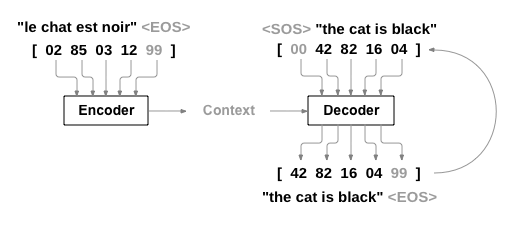

In contrast to sequence prediction using a single RNN, where each input corresponds to an output, the seq2seq model offers flexibility regarding sequence length and order. This property makes it well-suited for tasks such as translation between two languages.

Take, for example, the sentence ``Je ne suis pas le chat noir`` → ``I am not the black cat.`` While most words in the input sentence have direct translations in the output, they may appear in slightly different orders (e.g., ``chat noir`` and ``black cat``). Additionally, due to the presence of the ``ne/pas`` construction, there is an extra word in the input sentence. Directly generating a correct translation from the sequence of input words would be challenging.

In a seq2seq model, the encoder plays a crucial role by creating a single vector. In the ideal scenario, this vector encapsulates the "meaning" of the input sequence, representing a single point in some N-dimensional space of sentences. This ability to capture the essence of the input sequence in a condensed form enhances the model's capability to generate accurate translations, even when faced with variations in word order and additional linguistic complexities.

### The Encoder

The encoder component within a seq2seq network is a Recurrent Neural Network (RNN) responsible for producing an output for each word in the input sentence. As the encoder processes each input word, it generates both a vector and a hidden state. This hidden state is then employed as input for the subsequent word in the sequence. The iterative use of the hidden state facilitates the encoding of information from the entire input sentence, ensuring that the network captures the contextual relationships between words.

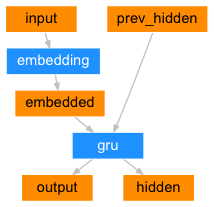

In [ ]:
# Define an EncoderRNN class that inherits from nn.Module
class EncoderRNN(nn.Module):
    # Constructor method to initialize the encoder
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        
        # Set the hidden size attribute
        self.hidden_size = hidden_size

        # Define an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Define a GRU (Gated Recurrent Unit) layer
        # input_size and hidden_size are both set to hidden_size, and batch_first is set to True
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Define a dropout layer with the specified dropout probability
        self.dropout = nn.Dropout(dropout_p)

    # Forward method to define the forward pass of the encoder
    def forward(self, input):
        """
        Define the forward pass of the encoder.

        Args:
        - input: Input tensor representing a sequence of indices (e.g., word indices).

        Returns:
        - output: Output tensor from the GRU layer.
        - hidden: Hidden state tensor from the GRU layer.
        """
        # Apply dropout to the input and pass it through the embedding layer
        embedded = self.dropout(self.embedding(input))
        
        # Pass the embedded input through the GRU layer
        # The output and hidden state are returned
        output, hidden = self.gru(embedded)

        # Return the output and hidden state
        return output, hidden

### The Decoder

The decoder is another Recurrent Neural Network (RNN) responsible for taking the encoder output vector(s) and generating a sequence of words to produce the translation.

#### Simple Decoder

In the basic seq2seq decoder, we utilize only the last output of the encoder. Referred to as the *context vector*, this output encapsulates context information from the entire sequence. The context vector serves as the initial hidden state for the decoder.

During each decoding step, the decoder receives an input token and a hidden state. The initial input token is the start-of-sequence `<SOS>` token, and the first hidden state is set to the `context vector`, which corresponds to the encoder's last hidden state.

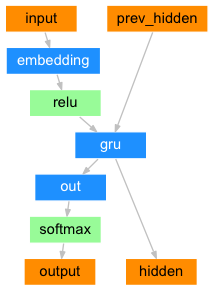

In [ ]:
# Define an DecoderRNN class that inherits from nn.Module
class DecoderRNN(nn.Module):
    # Constructor method to initialize the decoder
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        # Define an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # Define a GRU (Gated Recurrent Unit) layer
        # input_size and hidden_size are both set to hidden_size, and batch_first is set to True
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        # Define a linear layer for the output
        self.out = nn.Linear(hidden_size, output_size)

    # Forward method to define the forward pass of the decoder
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        
        # Initialize the decoder input with the start-of-sequence token (SOS_token)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        
        # Initialize the decoder hidden state with the encoder hidden state
        decoder_hidden = encoder_hidden
        
        # List to store decoder outputs at each step
        decoder_outputs = []

        # Loop through each step up to a maximum length (MAX_LENGTH)
        for i in range(MAX_LENGTH):
            # Perform a forward step using the forward_step method
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            
            # Append the decoder output to the list of outputs
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Detach from history as input

        # Concatenate the decoder outputs along the sequence dimension
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        
        # Apply log softmax to the concatenated outputs
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        
        # Return the decoder outputs, final hidden state, and None for consistency in the training loop
        return decoder_outputs, decoder_hidden, None

    # Method for a single forward step of the decoder
    def forward_step(self, input, hidden):
        # Pass the input through the embedding layer
        output = self.embedding(input)
        
        # Apply ReLU activation function
        output = F.relu(output)
        
        # Pass the output and hidden state through the GRU layer
        output, hidden = self.gru(output, hidden)
        
        # Pass the output through the linear layer for the final prediction
        output = self.out(output)
        
        # Return the output and hidden state
        return output, hidden

#### Attention Decoder

When only the `context vector` is transmitted between the encoder and decoder, that sole vector bears the responsibility of encapsulating the entire sentence's information.

Introducing attention mechanism enables the decoder network to dynamically "focus" on distinct portions of the encoder's outputs during each step of its own output generation. Initially, we compute a set of *attention weights*. These weights are then applied to the encoder's output vectors, resulting in a weighted combination. The outcome is expected to carry information specific to that particular segment of the input sequence. This mechanism aids the decoder in making informed decisions about the appropriate output words.

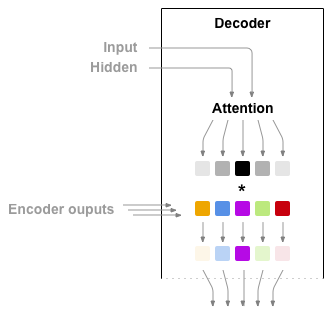

To compute the attention weights, a separate feed-forward layer  is employed. This layer takes the decoder's input and hidden state as inputs. Given that training data consists of sentences of varying lengths, we must establish a maximum sentence length (input length for encoder outputs) that this layer can handle. Sentences reaching the maximum length utilize all attention weights, whereas shorter sentences only utilize the initial weights up to their respective lengths.

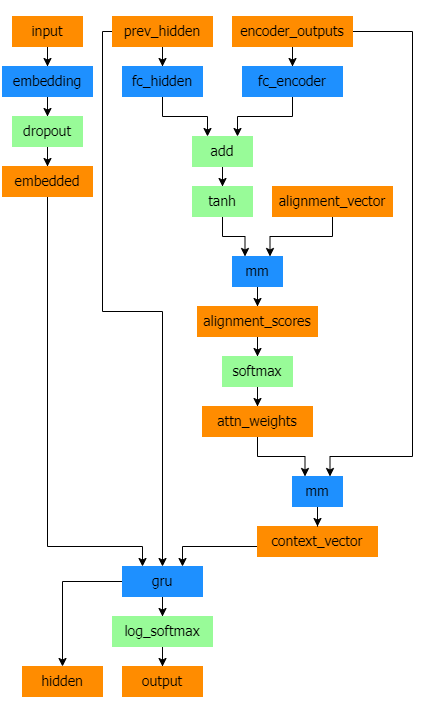

#### Additive Attention

Bahdanau attention, also referred to as additive attention, stands as a widely adopted attention mechanism in sequence-to-sequence models, especially in neural machine translation tasks. It was introduced by Bahdanau et al. in their paper titled [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf).

This attention mechanism incorporates a learned alignment model to compute attention scores between the hidden states of the encoder and decoder. It leverages a feed-forward neural network to calculate alignment scores.

While Bahdanau attention is commonly used, alternative attention mechanisms like Luong attention exist. Luong attention computes attention scores by taking the dot product between the decoder's hidden state and the encoder's hidden states, omitting the non-linear transformation employed in Bahdanau attention.

For the purposes of this tutorial, we will be utilizing Bahdanau attention. However, exploring the adaptation of the attention mechanism to incorporate Luong attention could serve as a valuable exercise.

In [ ]:
# Define a BahdanauAttention class that inherits from nn.Module
class BahdanauAttention(nn.Module):
    # Constructor method to initialize the attention mechanism
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        # Define linear transformation matrices Wa, Ua, and Va
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    # Forward method to define the forward pass of the attention mechanism
    def forward(self, query, keys):
        # Calculate attention scores using the content-based approach
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))

        # Squeeze the third dimension of scores and unsqueeze the first dimension
        scores = scores.squeeze(2).unsqueeze(1)

        # Apply softmax to calculate attention weights
        weights = F.softmax(scores, dim=-1)

        # Calculate the context vector by taking the weighted sum of keys
        context = torch.bmm(weights, keys)

        # Return the context vector and attention weights
        return context, weights

In [ ]:
# Define an AttnDecoderRNN class that inherits from nn.Module
class AttnDecoderRNN(nn.Module):
    # Constructor method to initialize the attention decoder
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Define an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # Define an attention mechanism using BahdanauAttention
        self.attention = BahdanauAttention(hidden_size)
        
        # Define a GRU (Gated Recurrent Unit) layer
        # The input size is 2 * hidden_size because it includes both embedded input and attention context
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        
        # Define a linear layer for the output
        self.out = nn.Linear(hidden_size, output_size)
        
        # Define a dropout layer with the specified dropout probability
        self.dropout = nn.Dropout(dropout_p)

    # Forward method to define the forward pass of the attention decoder
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        
        # Initialize the decoder input with the start-of-sequence token (SOS_token)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        
        # Initialize the decoder hidden state with the encoder hidden state
        decoder_hidden = encoder_hidden
        
        # Lists to store decoder outputs and attention weights at each step
        decoder_outputs = []
        attentions = []

        # Loop through each step up to a maximum length (MAX_LENGTH)
        for i in range(MAX_LENGTH):
            # Perform a forward step using the forward_step method
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # Append the decoder output and attention weights to the lists
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Detach from history as input

        # Concatenate the decoder outputs along the sequence dimension
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        
        # Apply log softmax to the concatenated outputs
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        
        # Concatenate the attention weights along the sequence dimension
        attentions = torch.cat(attentions, dim=1)

        # Return the decoder outputs, final hidden state, and attention weights
        return decoder_outputs, decoder_hidden, attentions

    # Method for a single forward step of the attention decoder
    def forward_step(self, input, hidden, encoder_outputs):
        # Pass the input through the embedding layer and apply dropout
        embedded =  self.dropout(self.embedding(input))

        # Permute the hidden state for attention calculation
        query = hidden.permute(1, 0, 2)
        
        # Calculate attention context and weights using the attention mechanism
        context, attn_weights = self.attention(query, encoder_outputs)
        
        # Concatenate the embedded input and attention context
        input_gru = torch.cat((embedded, context), dim=2)

        # Pass the concatenated input through the GRU layer
        output, hidden = self.gru(input_gru, hidden)
        
        # Pass the output through the linear layer for the final prediction
        output = self.out(output)

        # Return the output, hidden state, and attention weights
        return output, hidden, attn_weights

<div class="alert alert-info"><h4>Note</h4><p>Various attention mechanisms address the challenge of length limitation by adopting a relative position approach. One such approach is known as "local attention." For further insights into local attention and its effectiveness, refer to the paper titled: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025).</p></div>

## Training

### Preparing Training Data

For training purposes, we need to create input and target tensors for each pair. The input tensor contains the indexes of the words in the input sentence, and the target tensor contains the indexes of the words in the target sentence. During the creation of these vectors, we append the EOS (End-Of-Sequence) token to both sequences.

In [ ]:
def indexes_from_sentence(lang, sentence):
    """
    Convert a sentence into a list of indexes using a language object.

    Args:
    - lang: An instance of the Lang class containing word-to-index mapping.
    - sentence: The input sentence to be converted.

    Returns:
    - A list of indexes corresponding to the words in the sentence.
    """
    # Split the sentence into a list of words
    words = sentence.split(' ')

    # Use a list comprehension to get the index of each word from the language object
    # Note: lang.word2index is a dictionary mapping words to their corresponding indexes
    indexes = [lang.word2index[word] for word in words]

    # Return the list of indexes
    return indexes

In [ ]:
def tensor_from_sentence(lang, sentence):
    """
    Convert a sentence into a PyTorch tensor of indexes.

    Args:
    - lang: An instance of the Lang class containing word-to-index mapping.
    - sentence: The input sentence to be converted.

    Returns:
    - A PyTorch tensor representing the sentence with an additional EOS_token.
    """
    # Use the indexes_from_sentence function to get a list of indexes for each word
    indexes = indexes_from_sentence(lang, sentence)

    # Append the EOS_token to the list of indexes to indicate the end of the sentence
    indexes.append(EOS_token)

    # Convert the list of indexes to a PyTorch tensor
    # The tensor has a data type of long and is placed on the specified device (e.g., GPU)
    # The view(1, -1) operation reshapes the tensor into a 2D tensor with one row and a dynamic number of columns
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

In [ ]:
def tensors_from_pair(pair):
    """
    Convert a pair of input and target sentences into PyTorch tensors.

    Args:
    - pair: A tuple containing an input sentence (pair[0]) and a target sentence (pair[1]).

    Returns:
    - A tuple of PyTorch tensors representing the input and target sentences.
    """
    # Use the tensor_from_sentence function to convert the input sentence to a PyTorch tensor
    input_tensor = tensor_from_sentence(input_lang, pair[0])

    # Use the tensor_from_sentence function to convert the target sentence to a PyTorch tensor
    target_tensor = tensor_from_sentence(output_lang, pair[1])

    # Return a tuple containing the input and target tensors
    return (input_tensor, target_tensor)

In [ ]:
def get_dataloader(batch_size):
    """
    Prepare training data and create a PyTorch DataLoader.

    Args:
    - batch_size: Batch size for the DataLoader.

    Returns:
    - input_lang: Input language object.
    - output_lang: Output language object.
    - train_dataloader: PyTorch DataLoader for training data.
    """
    # Prepare data using the prepare_data function for English ('eng') and French ('fra') languages
    input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)

    # Get the number of pairs in the dataset
    n = len(pairs)

    # Initialize numpy arrays to store input and target sequences
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # Iterate through pairs and convert sentences to index sequences
    for idx, (inp, tgt) in enumerate(pairs):
        # Convert input and target sentences to index sequences
        inp_ids = indexes_from_sentence(input_lang, inp)
        tgt_ids = indexes_from_sentence(output_lang, tgt)

        # Append the EOS_token to mark the end of the sequences
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Pad the input and target sequences with zeros and store in numpy arrays
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Create a PyTorch TensorDataset from the numpy arrays
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    # Create a random sampler for the dataset
    train_sampler = RandomSampler(train_data)

    # Create a PyTorch DataLoader for training data
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Return input_lang, output_lang, and train_dataloader
    return input_lang, output_lang, train_dataloader

### Training the Model

**Key steps in training the encoder-decoder model:**

1. **Encoder processing:**
   - The input sentence is fed into the encoder.
   - All encoder outputs and the final hidden state are stored.

2. **Decoder initialization:**
   - The decoder starts with the `<SOS>` token as its first input.
   - The encoder's final hidden state is used as the decoder's initial hidden state.

**Teacher forcing:**

- **Concept:** Using the actual target outputs as inputs for the decoder during training, rather than its own predictions.
- **Pros:**
   - Faster convergence
- **Cons:**
   - Potential instability during inference (generating translations on its own)
   - Risk of producing grammatically correct but inaccurate translations

**Balancing teacher forcing:**

- PyTorch's autograd allows dynamic control of teacher forcing using a `teacher_forcing_ratio` parameter.
- Higher ratios increase the use of teacher forcing.
- Fine-tuning the ratio balances convergence speed with model robustness.

**Recommendations:**

- Use teacher forcing strategically, being mindful of its potential drawbacks. [When the trained
network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)
- Experiment with different `teacher_forcing_ratio` values to find the optimal balance for your specific model and dataset.
- Consider alternative techniques like Scheduled Sampling or Professor Forcing to further mitigate instability issues.

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    """
    Train one epoch of the Seq2Seq model.

    Args:
    - dataloader: PyTorch DataLoader containing training data.
    - encoder: Encoder model.
    - decoder: Decoder model.
    - encoder_optimizer: Optimizer for the encoder.
    - decoder_optimizer: Optimizer for the decoder.
    - criterion: Loss criterion.

    Returns:
    - Average loss for the epoch.
    """
    # Initialize the total loss for the epoch
    total_loss = 0

    # Iterate through batches in the dataloader
    for data in dataloader:
        # Unpack the input and target tensors from the data batch
        input_tensor, target_tensor = data

        # Zero the gradients of both the encoder and decoder optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Pass the input tensor through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pass the encoder outputs, hidden state, and target tensor through the decoder
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Flatten the outputs and targets for computing the loss
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        # Backpropagate the gradients
        loss.backward()

        # Update the encoder and decoder parameters using the optimizers
        encoder_optimizer.step()
        decoder_optimizer.step()

        # Accumulate the loss for the current batch
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Return the average loss for the epoch
    return average_loss

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.


**Functionality:**

- Tracks and displays the duration of a process as it runs.
- Estimates the remaining time based on current progress.
- Updates the user on progress and projected completion time.

**Key inputs:**

- Current time
- Progress percentage (representing how much of the process has been completed).

**Output:**

- Prints a user-friendly message that includes:
    - Time elapsed since the process began.
    - Estimated time remaining until completion.


In [ ]:
# Import the 'time' module
# The 'time' module provides various time-related functions.
import time

# Import the 'math' module
# The 'math' module provides mathematical functions and constants.
import math

In [ ]:
def format_duration(seconds):
    """
    Formats a duration in seconds to a human-readable string with minutes and seconds.

    Args:
        seconds (int): The duration in seconds.

    Returns:
        str: A string representing the formatted duration.
    """
    # Divide total seconds into minutes and remaining seconds
    minutes, seconds = divmod(seconds, 60)

    # Construct and return the formatted string
    return f"{minutes}m {round(seconds, 2)}s"

In [ ]:
def calculate_elapsed(start_time, progress_percent):
    """
    Calculates and formats the time elapsed and estimated time remaining for a process.

    Args:
        start_time (float): The time when the process started, in seconds.
        progress_percent (float): The current progress percentage of the process, as a value between 0 and 1.

    Returns:
        str: A formatted string containing the time elapsed and estimated time remaining.
    """

    # Get the current time
    current_time = time.time()

    # Calculate the time elapsed since the start of the process
    time_elapsed = current_time - start_time

    # Calculate the estimated total time based on the progress percentage
    estimated_total_time = time_elapsed / progress_percent

    # Calculate the estimated time remaining
    estimated_time_remaining = estimated_total_time - time_elapsed

    # Format the time elapsed and time remaining using the format_duration function
    formatted_time_elapsed = format_duration(time_elapsed)
    formatted_time_remaining = format_duration(estimated_time_remaining)

    # Return the formatted string containing the time elapsed and estimated time remaining
    return f"{formatted_time_elapsed} (- {formatted_time_remaining})"

The entire training procedure unfolds as follows:

1. **Start Timer:**
   - Begin tracking time.

2. **Initialize Optimizers and Criterion:**
   - Set up the optimizers and criterion for the training process.

3. **Create Training Pairs:**
   - Generate a set of training pairs.

4. **Initialize Empty Losses Array:**
   - Prepare an empty array to store losses for later visualization.

5. **Iteratively Execute Training Epochs:**
   - Repeatedly invoke the `train_epoch` function.
   - Periodically display progress updates, including the percentage of examples processed, the elapsed time, and the estimated time remaining.
   - Also, report the average loss during training.

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Train the Seq2Seq model for a specified number of epochs.

    Args:
    - train_dataloader: PyTorch DataLoader containing training data.
    - encoder: Encoder model.
    - decoder: Decoder model.
    - n_epochs: Number of training epochs.
    - learning_rate: Learning rate for optimization (default is 0.001).
    - print_every: Interval for printing training progress (default is 100).
    - plot_every: Interval for plotting training losses (default is 100).

    Returns:
    - None
    """
    # Record the start time of training
    start = time.time()

    # Lists to store plot losses for visualization
    plot_losses = []

    # Variables to track losses during printing and plotting
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Create Adam optimizers for encoder and decoder with the specified learning rate
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Define the negative log likelihood loss criterion
    criterion = nn.NLLLoss()

    # Loop over the specified number of epochs
    for epoch in range(1, n_epochs + 1):
        # Train the model for one epoch and get the average loss
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Update print and plot loss variables
        print_loss_total += loss
        plot_loss_total += loss

        # Print the average loss every 'print_every' epochs
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"{calculate_elapsed(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100}) {round(print_loss_avg, 3)}")

        # Plot the average loss every 'plot_every' epochs
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Visualize the training progress by plotting losses
    show_plot(plot_losses)

### Plotting results

The plotting process utilizes Matplotlib, leveraging the array of loss values (`plot_losses`) that was stored during the training phase.

In [ ]:
# Import the matplotlib.pyplot module for creating visualizations
import matplotlib.pyplot as plt

# Set the plotting backend to 'agg', often used for non-interactive environments
plt.switch_backend('agg')

# Import the matplotlib.ticker module for customizing plot axes
import matplotlib.ticker as ticker

# Import the numpy library for numerical computations and array manipulation
import numpy as np

In [ ]:
def show_plot(points):
    """
    Display a simple line plot of the given points with customized y-axis tick intervals.

    Args:
    - points: List of values to be plotted.

    Returns:
    - None
    """
    # Create a new figure
    plt.figure()

    # Create subplots (if needed)
    fig, ax = plt.subplots()

    # Configure the y-axis tick intervals
    # This locator puts ticks at regular intervals (every 0.2 in this case)
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    # Plot the points
    plt.plot(points)

## Evaluation

The evaluation process closely mirrors the training procedure, with the key distinction that no target values are provided. Instead, the decoder's predictions are recursively fed back into the decoder at each step. As the model predicts each word, it is appended to the output string, and the process continues until the `EOS` (End-Of-Sentence) token is predicted. Additionally, the attention outputs of the decoder are stored for later visualization.

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Evaluate a sequence using the trained encoder-decoder model.

    Args:
    - encoder: Trained encoder model.
    - decoder: Trained decoder model.
    - sentence: Input sequence to be evaluated.
    - input_lang: Language object for the input language.
    - output_lang: Language object for the output language.

    Returns:
    - Tuple containing the decoded words and attention weights.
    """
    # Use torch.no_grad() to disable gradient computation during evaluation
    with torch.no_grad():
        # Convert the input sentence to a PyTorch tensor
        input_tensor = tensor_from_sentence(input_lang, sentence)

        # Pass the input tensor through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pass the encoder outputs and hidden state through the decoder
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the index of the top predicted output for each position
        _, topi = decoder_outputs.topk(1)

        # Squeeze the tensor to remove unnecessary dimensions
        decoded_ids = topi.squeeze()

        # Initialize an empty list to store the decoded words
        decoded_words = []

        # Iterate through the decoded tensor indices
        for idx in decoded_ids:
            # Check if the current index corresponds to the EOS token
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break  # Exit the loop when EOS token is encountered
            # Append the corresponding word from the output language to the list
            decoded_words.append(output_lang.index2word[idx.item()])

    # Return the tuple containing the decoded words and attention weights
    return decoded_words, decoder_attn

To assess the model's performance, we'll analyze its output by inspecting random training sentences, along with their targets and the model's translations. By examining input-target-output triplets randomly sampled from the training data, we can gauge how well the model is performing.

In [ ]:
def evaluate_randomly(encoder, decoder, n=10):
    """
    Randomly select and evaluate n pairs from the dataset using the trained encoder-decoder model.

    Args:
    - encoder: Trained encoder model.
    - decoder: Trained decoder model.
    - n: Number of random pairs to evaluate (default is 10).

    Returns:
    - None
    """
    # Iterate through the specified number of random pairs
    for i in range(n):
        # Randomly select a pair from the dataset
        pair = random.choice(pairs)

        # Print the input sequence
        print('>', pair[0])

        # Print the target (ground truth) output sequence
        print('=', pair[1])

        # Call the evaluate function to obtain the model's predicted output
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        # Join the predicted output words into a sentence
        output_sentence = ' '.join(output_words)

        # Print the predicted output sequence
        print('<', output_sentence)

        # Print an empty line for better readability
        print('')

## Training and Evaluating

With these helper functions established (which may seem like additional effort but simplifies running multiple experiments), we can now initialize a neural network and commence training.

Recall that the input sentences underwent substantial filtering. Given the modest size of this dataset, we can employ relatively compact networks with 256 hidden nodes and a single GRU layer. After approximately 10 minutes on a Linux machine with a GPU, we can anticipate obtaining reasonable results.

In [ ]:
# Set the size of the hidden state in the models
hidden_size = 128

# Set the batch size for training
batch_size = 32

# Obtain the input and output languages, and the training dataloader
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# Create an instance of the EncoderRNN model with the specified parameters
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# Create an instance of the AttnDecoderRNN model with the specified parameters
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train the models using the training dataloader
# - The training process is run for 80 epochs
# - The 'print_every' parameter controls how often the training loss is printed
# - The 'plot_every' parameter controls how often the training loss is plotted
train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Switch the dropout layers to ``eval`` mode.

In [ ]:
# Set the encoder and decoder models to evaluation mode
encoder.eval()
decoder.eval()

# Evaluate the models by randomly selecting and evaluating sequences
evaluate_randomly(encoder, decoder)

### Visualizing Attention

The attention mechanism exhibits a valuable trait—its outputs are highly interpretable. As it is employed to assign weights to specific encoder outputs in the input sequence, we can visualize where the network places its focus at each time step.

To observe the attention output as a matrix, a simple approach is to use ``plt.matshow(attentions)``. For a more refined display, we will go the extra mile by incorporating axes and labels:

In [ ]:
def show_attention(input_sentence, output_words, attentions):
    """
    Display the attention weights as a heatmap.

    Args:
    - input_sentence: Input sequence as a string.
    - output_words: List of output words (predicted sequence).
    - attentions: Attention weights obtained from the model.

    Returns:
    - None
    """
    # Create a new figure for plotting
    fig = plt.figure()

    # Add a subplot to the figure
    ax = fig.add_subplot(111)

    # Create a color axis for the heatmap using matshow
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')

    # Add a colorbar to the figure
    fig.colorbar(cax)

    # Set up axes labels
    # - X-axis: Input sentence tokens along with '<EOS>' at the end
    # - Y-axis: Output words
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show a label at every tick on both axes
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Display the plot
    plt.show()

In [ ]:
def evaluate_and_show_attention(input_sentence):
    """
    Evaluate the input sentence using the trained encoder-decoder model and display attention visualization.

    Args:
    - input_sentence: Input sequence as a string.

    Returns:
    - None
    """
    # Call the evaluate function to obtain the model's predicted output and attention weights
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    # Print the input sentence
    print('input =', input_sentence)

    # Print the predicted output sequence
    print('output =', ' '.join(output_words))

    # Show attention visualization for the first output word
    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [ ]:
# Example usage:
# Evaluate and show attention for the given input sentences

# Example 1:
evaluate_and_show_attention('il n est pas aussi grand que son pere')

# Example 2:
evaluate_and_show_attention('je suis trop fatigue pour conduire')

# Example 3:
evaluate_and_show_attention('je suis desole si c est une question idiote')

# Example 4:
evaluate_and_show_attention('je suis reellement fiere de vous')

### Congratulations! You have completed this tutorial.